In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std



plt.rc("axes.spines", top=False, right=False)


import wrangle
import split_scale
import evaluate

Accuire Data

In [2]:
from env import host, user, password

In [3]:
#data for baseline model
df=wrangle.get_data_from_mysql()

In [4]:
df.head()

,parcelid,bedroomcnt,bathroomcnt,fips,squarefeet,taxvaluedollarcnt,taxamount,unitcnt,propertylandusetypeid,propertylandusedesc
0,11393337,3.0,3.0,6037.0,1534.0,43439.0,756.94,3.0,247.0,"Triplex (3 Units, Any Combination)"
1,11289917,3.0,2.0,6037.0,1458.0,136104.0,2319.90,1.0,261.0,Single Family Residential
2,11705026,2.0,1.0,6037.0,1421.0,35606.0,543.69,1.0,261.0,Single Family Residential
3,14269464,4.0,3.0,6059.0,2541.0,880456.0,9819.72,NaN,261.0,Single Family Residential
4,11389003,3.0,2.0,6037.0,1650.0,614000.0,7673.19,1.0,261.0,Single Family Residential


In [5]:
#data for tax rate distribution
df_tax = wrangle.taxcounty()

In [6]:
df_tax.head()

,tax_value,fips,taxamount,tax_rate
0,498347.0,6037.0,6089.82,0.0122
1,549917.0,6037.0,6679.55,0.0121
2,235272.0,6037.0,3876.31,0.0165
3,340000.0,6037.0,4206.15,0.0124
4,2017254.0,6037.0,24353.42,0.0121


Clean Data

In [7]:
df.head()

,parcelid,bedroomcnt,bathroomcnt,fips,squarefeet,taxvaluedollarcnt,taxamount,unitcnt,propertylandusetypeid,propertylandusedesc
0,11393337,3.0,3.0,6037.0,1534.0,43439.0,756.94,3.0,247.0,"Triplex (3 Units, Any Combination)"
1,11289917,3.0,2.0,6037.0,1458.0,136104.0,2319.90,1.0,261.0,Single Family Residential
2,11705026,2.0,1.0,6037.0,1421.0,35606.0,543.69,1.0,261.0,Single Family Residential
3,14269464,4.0,3.0,6059.0,2541.0,880456.0,9819.72,NaN,261.0,Single Family Residential
4,11389003,3.0,2.0,6037.0,1650.0,614000.0,7673.19,1.0,261.0,Single Family Residential


In [8]:
df_base = df.filter(['bedroomcnt','bathroomcnt','squarefeet', 'taxvaluedollarcnt'], axis=1)

In [9]:
df_base.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt
0,3.0,3.0,1534.0,43439.0
1,3.0,2.0,1458.0,136104.0
2,2.0,1.0,1421.0,35606.0
3,4.0,3.0,2541.0,880456.0
4,3.0,2.0,1650.0,614000.0


In [10]:
df_base.describe()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt
count,21882.000000,21882.000000,21882.000000,2.188200e+04
mean,3.073302,2.325679,1808.426926,5.019008e+05
std,1.116545,0.990098,973.442464,6.411898e+05
min,0.000000,0.000000,242.000000,1.050400e+04
25%,2.000000,2.000000,1194.000000,2.127882e+05
50%,3.000000,2.000000,1562.000000,3.680140e+05
75%,4.000000,3.000000,2145.000000,5.884635e+05
max,12.000000,11.000000,35640.000000,2.385837e+07


In [11]:
#acquiring county names based on fips field
#from: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
df_tax['county'] = np.where(df_tax['fips']== 6037,'Los Angeles',(np.where(df_tax['fips']== 6059,'Orange',(np.where(df_tax['fips']==6111,'Ventura',"")))))

In [12]:
df_tax.head()
df_tax.describe()

,tax_value,fips,taxamount,tax_rate
count,1.595600e+04,15956.000000,15956.000000,15956.000000
mean,4.634078e+05,6044.487591,5681.839846,0.013342
std,6.434229e+05,17.283469,7466.645847,0.003730
min,1.216800e+04,6037.000000,49.180000,0.000000
25%,1.820338e+05,6037.000000,2496.027500,0.011900
50%,3.205150e+05,6037.000000,4065.150000,0.012500
75%,5.286050e+05,6037.000000,6409.490000,0.013700
max,1.912982e+07,6111.000000,228999.210000,0.155100


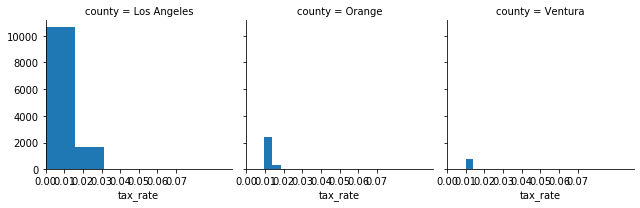

In [13]:
#Tax distribution by county.

from matplotlib import pyplot as plt

g = sns.FacetGrid(df_tax, col = "county")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.1)
plt.xticks(np.arange(0, .07, step=0.01))

plt.show()

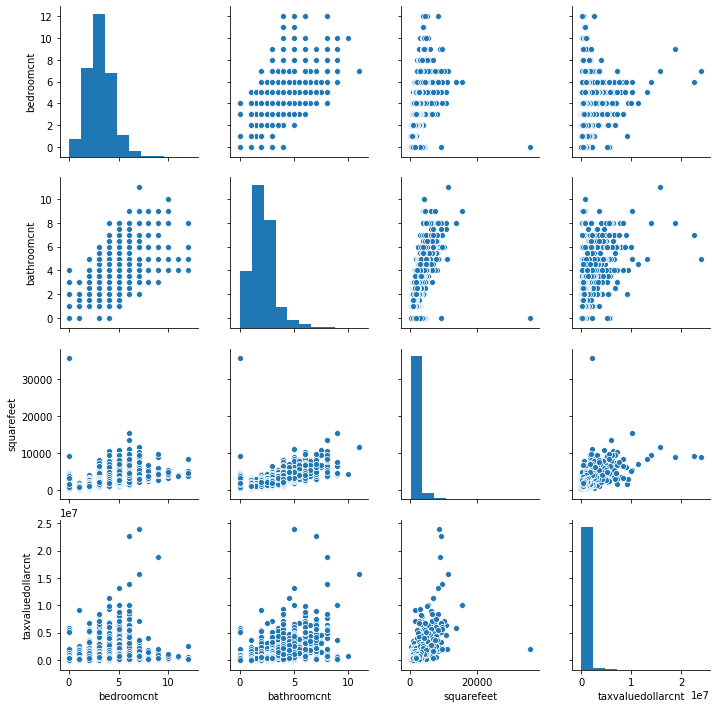

In [14]:
sns.pairplot(df_base)

Split and Scale

In [15]:
train, test = split_scale.split_my_data(df_base,train_ratio=.8,seed=123)

In [16]:
X_train = train.drop(columns='taxvaluedollarcnt')
y_train = train[['taxvaluedollarcnt']]
X_test = test.drop(columns='taxvaluedollarcnt')
y_test = test[['taxvaluedollarcnt']]

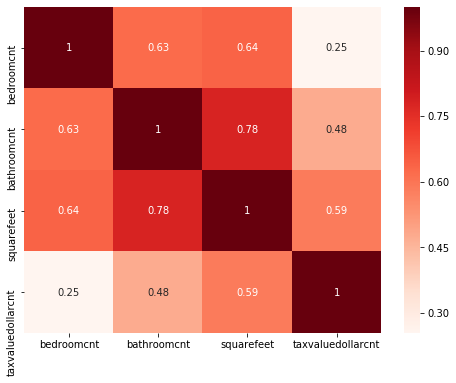

In [17]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train ~ X_train',data=train).fit()
train['yhat'] = ols_model.predict(y_train)

In [69]:
#r2 of 
r2_lm1_base = r2_score(y_train,train.yhat)
r2_lm1_base

0.373868433400525

In [20]:
#creating baseline with mean of tax value
train['taxvaluedollarcnt'] = train.taxvaluedollarcnt.mean()
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt,yhat
12988,6.0,5.0,3551.0,502083.199657,1.068855e+06
14084,3.0,2.0,1542.0,502083.199657,3.739359e+05
1154,2.0,2.0,1518.0,502083.199657,4.928182e+05
21500,5.0,3.0,2197.0,502083.199657,4.704110e+05
18037,2.0,1.0,924.0,502083.199657,1.640526e+05


In [21]:
#creating residual of tax value vs expected tax value
train['residual'] = train['yhat'] - train['taxvaluedollarcnt']
train['residual2'] = train.residual **2

In [22]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt,yhat,residual,residual2
12988,6.0,5.0,3551.0,502083.199657,1.068855e+06,566771.584649,3.212300e+11
14084,3.0,2.0,1542.0,502083.199657,3.739359e+05,-128147.321882,1.642174e+10
1154,2.0,2.0,1518.0,502083.199657,4.928182e+05,-9264.983175,8.583991e+07
21500,5.0,3.0,2197.0,502083.199657,4.704110e+05,-31672.170157,1.003126e+09
18037,2.0,1.0,924.0,502083.199657,1.640526e+05,-338030.642848,1.142647e+11


MVP

In [23]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm = LinearRegression()

In [24]:
#fit and train model
lm.fit(X_train,y_train)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

taxvaluedollarcnt = b + m1 * bedroomcnt + m2 * bathroomcnt
    y-intercept  (b): -45695.79
    coefficient (m1): -128988.50
    coefficient (m2): 78638.22


In [25]:
#converting y_train Series
y_train = y_train.taxvaluedollarcnt

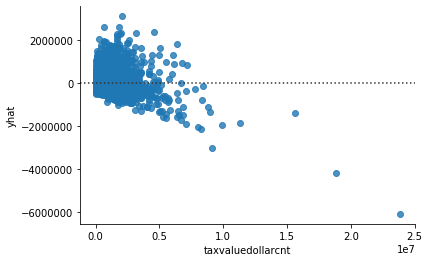

In [26]:
#Residuals
sns.residplot(y_train,train.yhat)

In [27]:
#MSE, SSE, RMSE
import math
sse = sum(train.residual2)
mse = sse/len(train)
rmse = math.sqrt(mse)
r2 = ols_model.rsquared
print(sse,mse,rmse,r2)

2542066997302060.0 145219479994.40503 381076.73767156794 0.373868433400525


In [28]:
print("R= ", r2)

R=  0.373868433400525


Text(0.5, 1, 'Predicted vs Actual Tax Value')

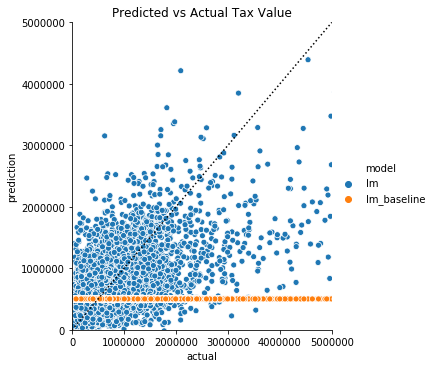

In [29]:
pd.DataFrame({'actual': y_train,
              'lm': train.yhat,
              'lm_baseline': train.taxvaluedollarcnt})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

In [30]:
mse_lm = mean_squared_error(y_train,train.taxvaluedollarcnt)
print("linear model\n  mean squared error: {:.3}".format(mse_lm)) 

linear model
  mean squared error: 3.88e+11


1st feature, just using Los Angeles data 

In [90]:
df_la = df_base[df.fips==6059]

In [91]:
df_la.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt
3,4.0,3.0,2541.0,880456.0
7,2.0,1.5,1277.0,95442.0
10,3.0,2.0,1668.0,196483.0
11,3.0,2.5,1653.0,605000.0
12,3.0,1.0,879.0,141875.0


Explore Los Angeles, with base data

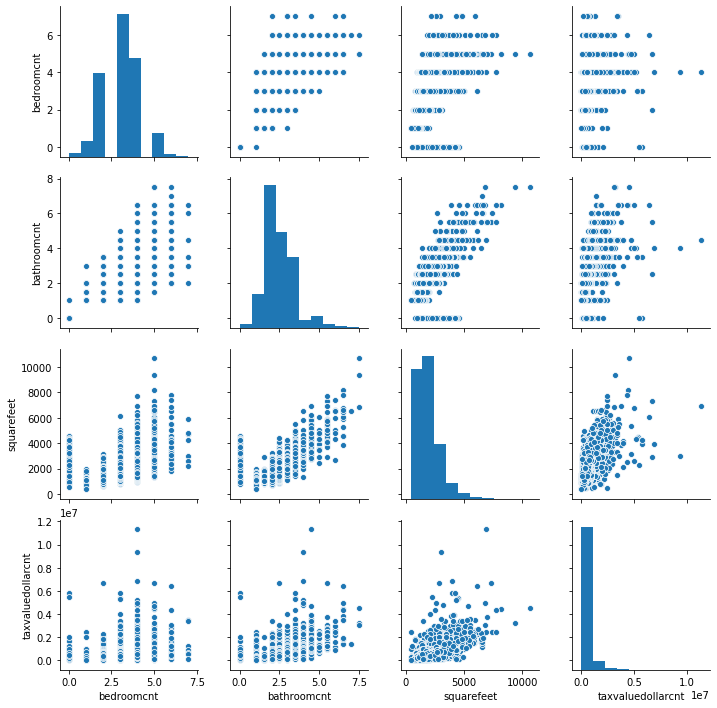

In [92]:
sns.pairplot(df_la)

Split LA Data

In [93]:
train_la, test_la = split_scale.split_my_data(df_la,train_ratio=.8,seed=123)

In [94]:
X_train_la = train_la.drop(columns='taxvaluedollarcnt')
y_train_la = train_la[['taxvaluedollarcnt']]
X_test_la = test_la.drop(columns='taxvaluedollarcnt')
y_test_la = test_la[['taxvaluedollarcnt']]

In [95]:
train_la.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt
9862,0.0,0.0,3912.0,364184.0
7003,2.0,2.0,1047.0,190818.0
20590,2.0,1.5,1028.0,256818.0
10751,2.0,2.0,1674.0,481605.0
3259,1.0,1.0,668.0,151063.0


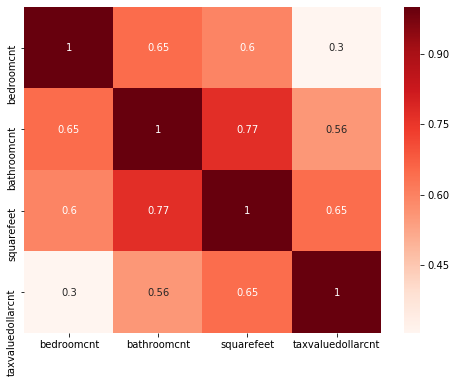

In [96]:
plt.figure(figsize=(8,6))
cor = train_la.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [97]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train_la ~ X_train_la',data=train_la).fit()
train_la['yhat_la'] = ols_model.predict(y_train_la)

In [98]:
#r2 of 
r2_lm1_la = r2_score(y_train_la,train_la.yhat_la)
r2_lm1_la

0.44724470631515245

MVP vs just using LA county information

In [74]:
#creating baseline with mean of tax value
train_la['taxvaluedollarcnt'] = train_la.taxvaluedollarcnt.mean()
train_la.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvaluedollarcnt,yhat_la
9862,0.0,0.0,3912.0,551037.011897,1.160283e+06
7003,2.0,2.0,1047.0,551037.011897,3.350448e+05
20590,2.0,1.5,1028.0,551037.011897,2.613973e+05
10751,2.0,2.0,1674.0,551037.011897,5.332408e+05
3259,1.0,1.0,668.0,551037.011897,1.750449e+05


In [99]:
#creating residual of tax value vs expected tax value
train_la['residual_la'] = train_la['yhat_la'] - train_la['taxvaluedollarcnt']
train_la['residual2_la'] = train_la.residual_la **2

Evaluate

In [100]:
 #fit and train model
lm.fit(X_train_la,y_train_la)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train_la.columns[0], X_train_la.columns[0],X_train_la.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

taxvaluedollarcnt = b + m1 * bedroomcnt + m2 * bathroomcnt
    y-intercept  (b): -76308.50
    coefficient (m1): -95085.92
    coefficient (m2): 135283.11


In [101]:
#converting y_train Series
y_train_la= y_train_la.taxvaluedollarcnt

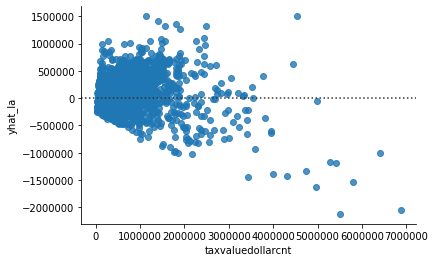

In [102]:
#Residuals
sns.residplot(y_train_la,train_la.yhat_la)

In [110]:
#MSE, SSE, RMSE
import math
sse_la = sum(train_la.residual2_la)
mse_la = sse_la/len(train_la)
rmse_la = math.sqrt(mse_la)
r2_la= ols_model.rsquared
print(sse_la,mse_la,rmse_la,r2_la)

678732310583003.8 144196369361.165 379731.9704227773 0.44724470631515245


In [112]:
print("R_la= ", r2_la)


R_la=  0.44724470631515245


Text(0.5, 1, 'Predicted vs Actual Tax Value')

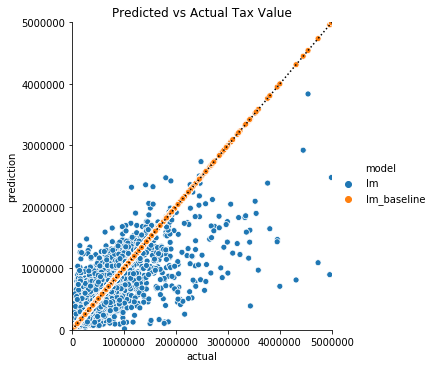

In [113]:
pd.DataFrame({'actual': y_train_la,
              'lm': train_la.yhat_la,
              'lm_baseline': train_la.taxvaluedollarcnt})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')